# Darwin: optimization vs understanding (I feel the need for speed)

In today’s world speed is everything (okay nearly everything). We value progress over perfection at AA. Keeping that in mind, statistics are complex, time consuming, and difficult to understand. We have been looking for ways to make it faster, simpler to understand, and establish a common language for everyone from our math nerds to our non technical creative types.

We are a data driven company, and that means metrics. Most of our metrics are per user, things like impressions per user, revenue per user, visits per user, engagement per user, clicks per user, etc.

We conduct experiments that generally try to increase or decrease one or more of those metrics. In other words we try to answer the question, do people press the button more if the color is blue or red, or does it matter at all? All of our metrics have variance (no suprise there). The data used to calculate them is noisey, sometimes incomplete, and doesn't perfectly fit into one of the 'standard' distrobution models. That’s what makes doing this work challenging. Over the last year we have developed a methodology for comparing the relative performance of the metrics under test.

We call the methodology that we use ‘Pwin’ or probability of winning. It combines three statistics tools bootstrapping (aka resampling), probability density functions (pdf’s), and Montecarlo simulation.

The examples are coded in python 2.7 and developed using Cloud Datalab and is available in python notebook for at https://github.com/tkemmerling/pwin

In [2]:
import os.path
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

This function generates a random normal dataset. We will use these examples to illustrate some of the issues in our data.

In [5]:
def genSample(mu, sigma, size):
  rval = np.random.normal(loc=mu, scale=sigma, size=size)
  return ( pd.Series(rval) )

In [6]:
sample1 = genSample(1,0.25,100000)
sample2 = genSample(1.1,0.25,100000)

Below we see a historgram of each sample. It shows that there is lots of overlap in the samples, the variance in the data is obvious. By looking at this plot it appears that sample2 is showing a higher mean than sample1. Since we know that it is easy to intuit.

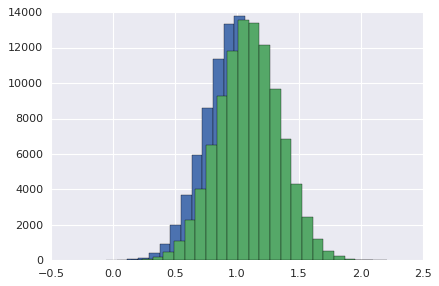

In [9]:
f = sample1.hist(bins = 25)
f = sample2.hist(bins = 25)

The next function generates a dataset that is more representive of what we see at AA. The data set produced has a number of ‘hotspots’ or clusters of values that are distributed over a larger range.

In [10]:
def genSampleNoisy(mu, sigma, size, steps = None, sparseness = None ):
  rval = list()
  values = list()
  for plusMinus in [-1.0, 1.0]:
    for step in steps:
      m = (plusMinus * step) + mu
      values.append(m)
  values.append(mu)
  values.sort()
  idx = 0
  for s in sparseness:
    pieceSize = int(s * size)
    samplePiece = np.random.normal(loc=values[idx], scale=sigma, size=pieceSize)
    rval = rval + list(samplePiece)
    idx += 1
  return ( pd.Series(rval) )

Now we look at the sample plot using a more realistic dataset. It is not much harder to intuit who the winner is.

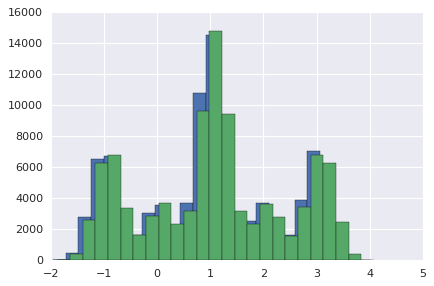

In [14]:
sample3 = genSampleNoisy(1,0.25,100000, steps=[1,2], sparseness=[.2,.1,.4,.1,.2])
sample4 = genSampleNoisy(1.1,0.25,100000, steps=[1,2], sparseness=[.2,.1,.4,.1,.2])
g = sample3.hist(bins=25)
g = sample4.hist(bins=25)

So at this point you should be able to see the problem that we need to deal with. We need to pick a winner, so we do statistics. We start hearing sentence fragments that include things like 'we want a P value of', 'two tailed t-test', 'confidence intervals', etc.

Taking a step back for a minute, we know that the mean of sample 4 is larger than the mean of sample 3. Why don't we just run with that? Because the data is nosiey we are concerned that we might be wrong. So the first thing we would like to know is how much could our estimate of the mean of these samples be wrong by? That is where we pull in the first our tools 'Bootstrapping'.

We use bootrapping to estimate the variance of the means of our two samples. In other words based on the data we have how much could the test statistic vary. How much could the mean of these two samples be wrong by?

The function below is a very simple implementation of the bootstrap algorithm. What is does is resample with replacement a given data set, calculate the mean of the new sample, store that away, and repeat this R time. It returns dataset of the bootstapped means.

In [16]:
def Bootstrap(data, R = 1000):
    rval = list()
    r = 0
    sampleSize = len(data)
    while r < R:
            tsample = data.sample(n=sampleSize, replace=True)
            avg = tsample.mean()
            rval.append(avg)
            r += 1
    return (pd.Series(rval))

First we bootstrap all of the generated samples.

In [17]:
v1 = Bootstrap(sample1, 2500)
v2 = Bootstrap(sample2, 2500)
v3 = Bootstrap(sample3, 2500)
v4 = Bootstrap(sample4, 2500)

Let start by looking at the first samples we generated. What the plots show us are two things. First that the variance of the mean of each sample is very small. We should expect this because the samples are normal and continous. Second the plot pretty clearly shows that sample2 has a large mean than sample1 and that there is very little chance of an error based on the data we have collect.

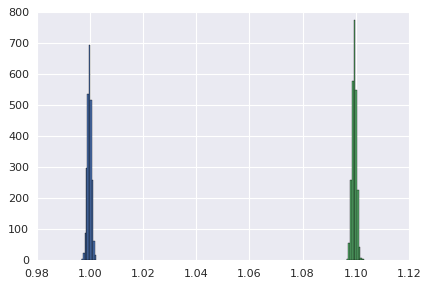

In [19]:
v = v1.hist()
v = v2.hist()

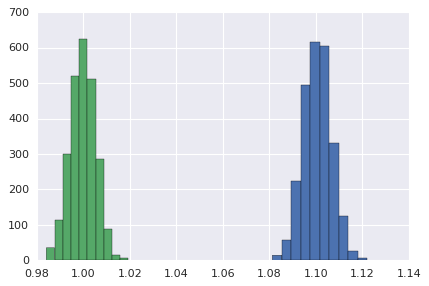

In [13]:
v3.hist()
v4.hist()

In [22]:
print stats.norm.fit(v1.tolist())
print stats.norm.fit(v2.tolist())

(0.99890429717956863, 0.00078227330525242153)
(1.1017442589506594, 0.00079230803544574446)


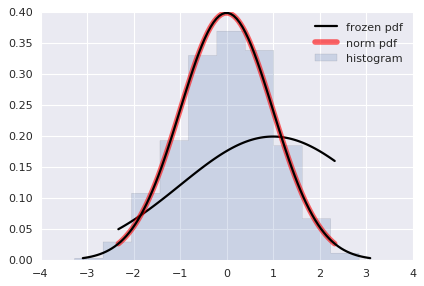

In [73]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
rv = norm(1,2)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

r = norm.rvs(size=1000)
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2, label = 'histogram')
ax.legend(loc='best', frameon=False)


x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


plt.show()

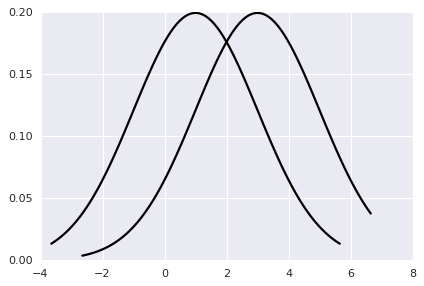

In [74]:
fi, ay = plt.subplots(1, 1)
rv1 = norm(1,2)
rv2 = norm(2,2)
x1 = np.linspace(rv1.ppf(0.01), rv1.ppf(0.99), 100)
x2 = np.linspace(rv2.ppf(0.01), rv2.ppf(0.99), 100)
ay.plot(x1, rv1.pdf(x1), 'k-', lw=2, label='rv1')
ay.plot(x2, rv2.pdf(x1), 'k-', lw=2, label='rv1')

### Links to reference materials

https://en.wikipedia.org/wiki/Monte_Carlo_method
https://en.wikipedia.org/wiki/Normal_distribution
https://en.wikipedia.org/wiki/Gamma_distribution
https://en.wikipedia.org/wiki/Bootstrapping_(statistics)